# AI for Earth System Science Hackathon 2020
# GOES Challenge
David John Gagne, Gunther Wallach, Charlie Becker, Bill Petzke

## Introduction
![GOES-R satellite image from Wikipedia](goes_images/GOES-R_SPACECRAFT.jpg)

Lightning kills roughly 30 people per year in the United States (https://www.weather.gov/safety/lightning-victims) and can have large economic impacts by disrupting outdoor work and events and by sparking fires. Improved short term prediction of lightning onset can help protect life and property by ensuring that people can get to safety with sufficient lead time. The economic impacts of lightning protection practices can also be reduced by improving the prediction of when lightning is expected to end. 

Recently deployed observational systems combined with advances in machine learning have the potential to improve the short-term prediction of lightning by associating broader scale weather patterns with the future occurrence of lightning in that area. The Geostationary Operational Environmental Satellite 16 (GOES-16) is a weather satellite that orbits the Earth at a fixed point situated along the same longitude as the Eastern United States and can provide a hemispheric, multispectral view of cloud patterns at high space and time resolution through its Advanced Baseline Imager (ABI) camera. The satellite also holds the Geostationary Lightning Mapper (GLM) instrument that records lightning flashes across the hemispheric view of the satellite. By combining the data collected by these two instruments, we can develop new machine learning solutions to the challenge of short range lightning prediction.  

## Software Requirements
This notebook requires Python >= 3.7. The following libraries are required:
* numpy
* scipy
* matplotlib
* xarray
* pandas
* scikit-learn
* tensorflow >= 2.1
* netcdf4
* tqdm


In [1]:
! pip install numpy scipy matplotlib xarray pandas netcdf4 h5netcdf tqdm tensorflow scikit-learn dask s3fs goes16ci seaborn xgboost

     |████████████████████████████████| 4.1MB 5.2MB/s 
     |████████████████████████████████| 327kB 40.9MB/s 


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import xarray as xr
import tensorflow as tf
import matplotlib.pyplot as plt
from dask.distributed import Client, LocalCluster, progress
from goes16ci.models import StandardConvNet, ResNet, MinMaxScaler2D
import s3fs
from glob import glob
from sklearn import preprocessing
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.decomposition import PCA


# Set random seed
seed = 3985
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

gpus = tf.config.get_visible_devices("GPU")
for device in gpus:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)

## Data

### Data Generation


There are several GOES-16 data products available. We are primarily interested in the water vapor bands from the Advanced Baseline Imager (ABI) and lightning counts from the Geostationary Lightning Mapper (GLM). The ABI camera’s spatial resolution is 2 km with a temporal resolution of 5 minutes. We chose to select/crop 32 x 32 sized image patches (for each band) across our domain (CONUS Midwest) at an upsampled rate of every 20 minutes from 2019-03-02 through 2019-10-01. We used these same spatio-temporal patches to aggregate all lightning flash counts within that patch but lagged by one hour. Total aggregated data was output at a daily interval.  

### Useful Links

[Overall GOES-16 Band Reference Guide](https://www.weather.gov/media/crp/GOES_16_Guides_FINALBIS.pdf)

[GOES-16 Band 08 Info (Upper-level Water Vapor)](http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band08.pdf)

[GOES-16 Band 09 Info (Mid-level Water Vapor)](http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band09.pdf)

[GOES-16 Band 10 Info (Low-level Water Vapor)](http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band10.pdf)

[GOES-16 Band 14 Info (Longwave Window)](http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band14.pdf)

[GOES-16 Geostationary Lightning Mapper (GLM)](https://www.goes-r.gov/spacesegment/glm.html)


### Time span of the dataset

|  | Date/Time | 
| ------------- | :---- |
| Start | 2019-03-02 00:20:00 | 
| End | 2019-10-02 00:00:00 |
| Timestep | 00:20:00 | 
| NOTE: some days are missing (intentionally skipped) to isolate convective cycles





### Geographic Coverage of Dataset (Mostly Midwest CONUS)

|  | Latitude | Longitude |
| ------------- | :----:|:- |
| Min | 29.09 | -97.77 |
| Max | 48.97 | -82.53 |




### Dimensions

| Dimension Name | Description | Size |
| ------------- | :----:|:----------- |
| Band     | ABI Band Number  | 4 (Bands 8,9,10,14) |
| Patch      | spatio-temporal patch | ~3600 per day |
| X      | X-plane | 32 |
| Y      | Y-plane | 32 |

### Potential Input Variables

| Variable Name | Units | Description | 
| ------------- | :----:|:----------- | 
| abi (Band 08)   | K     | Upper-level Water Vapor | 
| abi (Band 09)   | K     | Mid-level Water Vapor   |
| abi (Band 10)   | K     | Lower-level Water Vapor |
| abi (Band 14)   | K     | Longwave Window         |

### Output Variables

| Variable Name | Units | Description |
| ------------- | :----:|:----------- |
| flash_counts    | -     | Lightning strike count |


### Metadata Variables

| Variable Name | Units | Description |
| ------------- | :----:|:----------- |
| Time     | YYYY-MM-DDTHH:MM:SS  | The Date   |
| Lat      | Degrees     | Latitude   |
| Lon      | Degrees     | Longitude  |


### Training/Validation/Testing Sets

The function `split_data_files()` will split the data files into approximately equal partitions for training/validation/testing. By default, it takes 4-day contiguous data “chunks” per partition while skipping 1 day between to isolate convective cycles (and thus not validate/test on data linked to the training data), and repeats throughout the selected timespan.  Thus, each set should contain approximately 210,000 (32 x 32)  samples (patches) if the entire timespan is used.


In [ ]:
# How to load the data from disk or cloud

def split_data_files(dir_path="ncar-aiml-data-commons/goes/ABI_patches_32/", file_prefix='abi_patches_', 
               start_date='20190302', end_date='20191001', seq_len=4, skip_len=1):
    """
    Take daily ABI patch files and split into equal training/validation/testing
    semi-contiguous partitions, skipping day(s) between chunks to isolate convective 
    cycles.
    
    Args: 
        dir_path: (str) Directory path to daily ABI files
        file_prefix: (str) File prefix up to date 
        start_date: (str) Starting date to get files in format of YYYYMMDD
        end_date: (str) Ending date to get files in format of YYYYMMDD
        seq_len: (int) Length of days per 'chunk' of data
        skip_len: (int) How many days to skip between data chunks
        
    Returns:
        train_f, val_f, test_f: list of training/validation/test files
    """
    
    all_files = fs.ls(dir_path)
    start_index = all_files.index('{}{}{}T000000.nc'.format(dir_path, file_prefix, start_date))
    end_index = all_files.index('{}{}{}T000000.nc'.format(dir_path, file_prefix, end_date))
    file_spread = all_files[start_index:end_index+1]
    
    train_files, val_files, test_files = [], [], []
    
    for i in np.arange(0, len(file_spread)+1, (seq_len+skip_len)*3):
        
        val_i = i + seq_len + skip_len
        test_i = i + (seq_len + skip_len)*2
        
        train_files.append(file_spread[i:i+seq_len])
        val_files.append(file_spread[val_i:val_i+seq_len])
        test_files.append(file_spread[test_i:test_i+seq_len])
        
    train_f = [item for sublist in train_files for item in sublist]
    val_f = [item for sublist in val_files for item in sublist]
    test_f = [item for sublist in test_files for item in sublist]
    
    return train_f, val_f, test_f

def fetch_data(file_number, file_list):
    """
    Function to be distributed across a cluster to individually load files directly from an AWS S3 bucket 
    
    Args:
        file_number: index for file from file_list
        file_list: List of files to index from
    Returns:
        ds: xarray dataset of daily file 
    """
    obj = fs.open(file_list[file_number])
    ds = xr.open_dataset(obj, chunks={})
    
    return ds

def merge_data(file_list):
    """
    Take a list of files and distribute across a cluster to be loaded then gathered and concantenated
    
    Args:
        file_list: List of files to be merged together (training, validation, or testing)
    Returns:
        merged_data: Concatenated xarray dataset of training, validation, or testing data 
    """
    futures = client.map(fetch_data, range(len(file_list)), [file_list]*len(file_list))
    results = client.gather(futures)
    merged_data = xr.concat(results, 'patch').compute()
    
    return merged_data

def prepare_data(data):
    """
    Take GOES netCDF data, filter out NaNs, reshape for tensorflow, convert flash_counts to binary,
    and return filtered numpy arrays
    Args:
        data: GOES patch netCDF data including ABI bands and lightning flash counts
    Returns:
        good_imagery: NaN filtered numpy array with reshaped dimensions (patch, x, y, band)
        binary_output: 1D numpy array of lightnin flash_counts
    """
    
    input_data = np.moveaxis(data['abi'].values, 1, -1)
    output_data = data['flash_counts'].values
    
    nan_indices = np.unique(np.where(np.isnan(input_data))[0])
    all_indices = np.arange(input_data.shape[0])
    valid_indices = all_indices[np.isin(all_indices, nan_indices, assume_unique=True, invert=True)]
    
    good_imagery = input_data[valid_indices]
    binary_output = np.where(output_data > 0, 1, 0)[valid_indices]
    
    return good_imagery, binary_output

We use DASK to create a local cluster to speed up the data loading process (Loading data directly from an AWS S3 bucket can be slow).

In [ ]:
cluster = LocalCluster(processes=True, threads_per_worker=2)
client = Client(cluster)
fs = s3fs.S3FileSystem(anon=True)

In [ ]:
%%time
# Split into training, validation, and test sets
# We only load the train and val sets here to save a couple minutes
train_files, val_files, test_files = split_data_files()
train, val = map(merge_data, [train_files, val_files])

CPU times: user 20.7 s, sys: 32.3 s, total: 53 s
Wall time: 4min 43s


In [ ]:
client.close()

In [ ]:
cluster.close()

## Exploratory visualizations

When seperating by band, lightning active patches usually have a similar brightness temperature (BT) profiles throughout the 4 water vapor channels. Low BT convective cells are often seen as well (as expected).

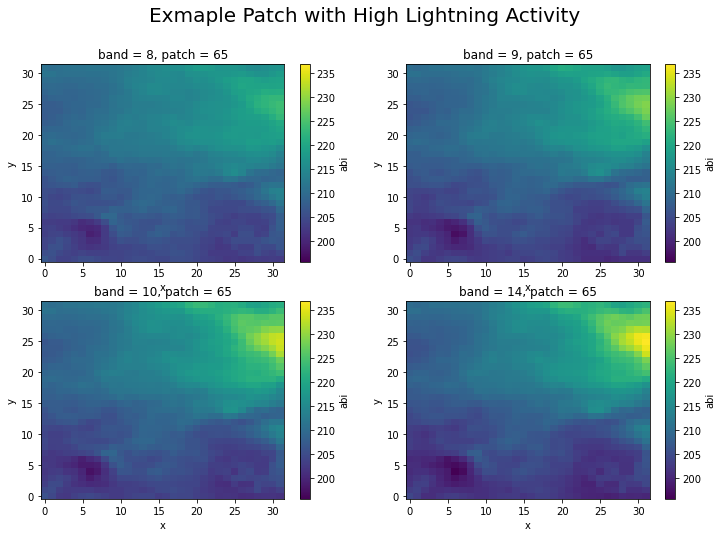

In [ ]:
high_lc_indices = np.argwhere(train.flash_counts.values > 100).flatten() # indices with more than 100 lightning counts
no_lc_indices = np.argwhere(train.flash_counts.values == 0).flatten() # indices with no lightning counts

index = high_lc_indices[100]
vmin = train['abi'][index,:,:,:].min() # set min/max plotting range  
vmax = train['abi'][index,:,:,:].max()

fig, ax = plt.subplots(2,2, figsize=(12,8))
for i in range(4):
    train['abi'][index,i,:,:].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)
    plt.suptitle('Exmaple Patch with High Lightning Activity', fontsize=20)

Areas without lightning activity often exibit a much larger BT range throughout the channel column, particularily the longwave window (Band 14) which often has much higher values with clear skies.

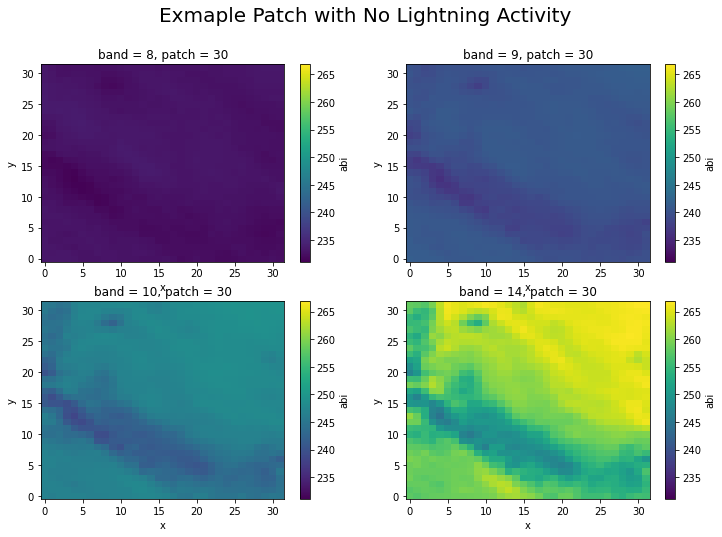

In [ ]:
index = no_lc_indices[30]
vmin = train['abi'][index,:,:,:].min() # set min/max plotting range
vmax = train['abi'][index,:,:,:].max() # set min/max plotting range

fig, ax = plt.subplots(2,2, figsize=(12,8))
for i in range(4):
    train['abi'][index,i,:,:].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)
    plt.suptitle('Exmaple Patch with No Lightning Activity', fontsize=20)

This pattern is also noted when taking the mean value of each patch across the dataset.

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


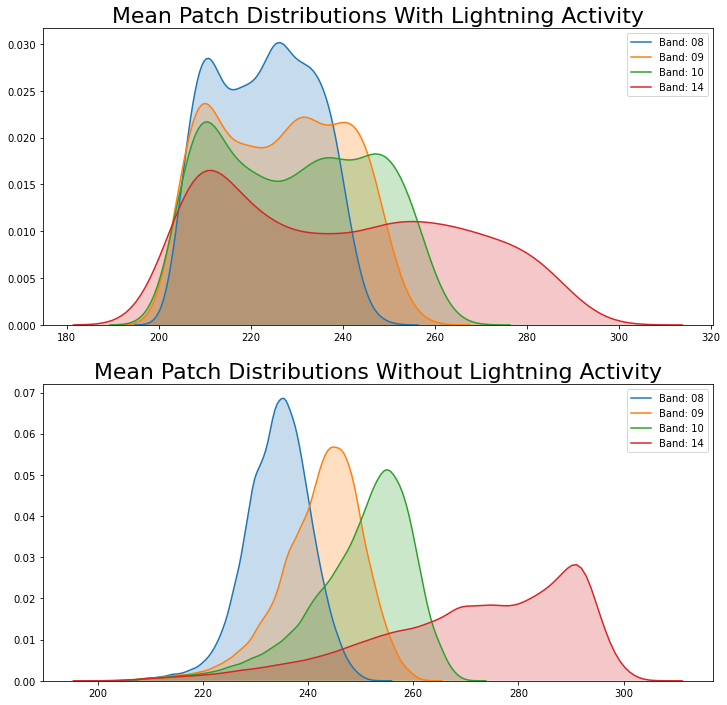

In [ ]:
lc_train = train.isel(patch=high_lc_indices) # all patch data with lightning counts (above threshold)
no_lc_train = train.isel(patch=no_lc_indices) # all patch data without lightning activity
mean_patches_lc = lc_train.abi.mean(dim=('x','y')) # mean BT of each patch
mean_patches_no_lc = no_lc_train.abi.mean(dim=('x','y')) # mean BT of each patch

fig, ax = plt.subplots(2,1, figsize=(12,12))
for i,lab in enumerate(['Band: 08', 'Band: 09', 'Band: 10', 'Band: 14']*2):
    if i < 4:
        sns.kdeplot(mean_patches_lc[:,i], ax=ax[0], label=lab, shade=True).set_title(
            'Mean Patch Distributions With Lightning Activity', fontsize=22)
    else:
        sns.kdeplot(mean_patches_no_lc[:,i-4], ax=ax[1], label=lab, shade=True).set_title(
            'Mean Patch Distributions Without Lightning Activity', fontsize=22)

### Data Transforms
Discuss any transforms or normalizations that may be needed for this dataset. Remember to fit a scaler only to the training data and then apply it on testing and validation.

In [ ]:
# Visual of input variable before and after transform
# Example of data transform procedure for dataset

In [ ]:
%%time
# get numpy arrays of patch data for each band (this also converts all flash_counts to binary classes)
train_in, train_out = prepare_data(train) 
val_in, val_out = prepare_data(val)

# scale data
scaler = MinMaxScaler2D()
scaled_train_in = scaler.fit_transform(train_in)
scaled_val_in = scaler.transform(val_in)

CPU times: user 16.8 s, sys: 5.68 s, total: 22.5 s
Wall time: 22.4 s


In [ ]:
# declare ResNet (residual network from the goes16i module) and list the default parameters
# Any of these parameters can be overridden
# note using larger batch sizes here can cause memory errors
resNet_mod = ResNet(epochs=5, batch_size=512)
vars(resNet_mod)

{'min_filters': 16,
 'filter_width': 3,
 'filter_growth_rate': 2,
 'min_data_width': 4,
 'hidden_activation': 'relu',
 'output_activation': 'sigmoid',
 'use_dropout': False,
 'pooling': 'mean',
 'dropout_alpha': 0.0,
 'data_format': 'channels_last',
 'optimizer': 'adam',
 'learning_rate': 0.001,
 'loss': 'mse',
 'metrics': None,
 'leaky_alpha': 0.1,
 'batch_size': 512,
 'epochs': 5,
 'sgd_momentum': 0.99,
 'model': None,
 'parallel_model': None,
 'time_history': <goes16ci.models.TimeHistory at 0x7f075a4dde10>,
 'loss_history': <goes16ci.models.LossHistory at 0x7f075a4ddf90>,
 'verbose': 0}

In [ ]:
%%time
# Fit model and print architecture
resNet_mod.fit(scaled_train_in, train_out, scaled_val_in, val_out)
resNet_mod.model.summary()

{'loss': 0.08051272481679916, 'val_loss': 0.24432414770126343}
{'loss': 0.06826464831829071, 'val_loss': 0.11906398087739944}
{'loss': 0.06445411592721939, 'val_loss': 0.09343528747558594}
{'loss': 0.06292682886123657, 'val_loss': 0.09031521528959274}
{'loss': 0.060944847762584686, 'val_loss': 0.14798516035079956}
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scn_input (InputLayer)          [(None, 32, 32, 4)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   592         scn_input[0][0]                  
__________________________________________________________________________________________________
bn_res_00_a (BatchNormalization (None, 32, 32, 16)   64          conv2d[0][

## Baseline ResNet Evaluation Metrics
We trained on binary output data, but output probabilities before converting to class. This allows us to evaluate regressed and classified metrics:


| Type | Metric | Value to beat |
| ------------- | :----:|:-------|
|  Regressed   ||   
|              | RMSE: |0.328|
|              | R2: |0.567 |
|              | Hellenger Distance: |0.501|
|||
| Classified   |||
|              | Heidke Skill Score: |0.705|
|              | Peirce Skill Score:  |0.713|
|              | Brier Score: |0.143|
|              | Brier Skill Score: |0.402|
|              | AUC: |0.856|

In [ ]:
# set the probability threshold for binary classification; predict on validation; add binary preds
binary_threshold = 0.5
preds = resNet_mod.predict(scaled_val_in).reshape(val_out.shape[0])
binary_preds = np.where(preds >= binary_threshold, 1, 0)

In [ ]:
# Metric functions
from sklearn.metrics import confusion_matrix, mean_squared_error, brier_score_loss, roc_auc_score

import numpy as np

def calc_pdf_hist(x, x_bins):
    return np.histogram(x, x_bins, density=True)[0]

def auc_score(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)

def brier_score(y_true, y_pred):
    return brier_score_loss(y_true, y_pred)

def brier_skill_score(y_true, y_pred):
    
    model_brier_score = mean_squared_error(y_true, y_pred)
    climo_brier_score = mean_squared_error(y_true, np.ones(y_true.size) * y_true.sum() / y_true.size)
    model_brier_skill_score = 1 - model_brier_score / climo_brier_score
    return model_brier_skill_score

def hellinger(x, pdf_p, pdf_q):
    pdf_distances = (np.sqrt(pdf_p) - np.sqrt(pdf_q)) ** 2
    return np.trapz(pdf_distances, x) / 2

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def hellinger_distance(y_true, y_pred, bins=50):
    bin_points = np.linspace(np.minimum(y_true.min(), y_pred.min()),
                       np.maximum(y_true.max(), y_pred.max()),
                       bins)
    bin_centers = 0.5 * (bin_points[:-1] + bin_points[1:])
    y_true_pdf = calc_pdf_hist(y_true, bin_points)
    y_pred_pdf = calc_pdf_hist(y_pred, bin_points)
    return hellinger(bin_centers, y_true_pdf, y_pred_pdf)

def peirce_skill_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    n = float(cm.sum())
    nf = cm.sum(axis=0)
    no = cm.sum(axis=1)
    correct = float(cm.trace())
    return (correct / n - (nf * no).sum() / n ** 2) / (1 - (no * no).sum() / n ** 2)

def heidke_skill_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    n = float(cm.sum())
    nf = cm.sum(axis=0)
    no = cm.sum(axis=1)
    correct = float(cm.trace())
    return (correct / n - (nf * no).sum() / n ** 2) / (1 - (nf * no).sum() / n ** 2)

def r2_corr(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1] ** 2

In [ ]:
# Example regressed metrics
print('RMSE: {}'.format(np.round(root_mean_squared_error(val_out, preds),3)))
print('R squared: {}'.format(np.round(r2_corr(val_out, preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_out, preds),3)))

# Example classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(val_out, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, binary_preds),3)))
print('AUC: {}'.format(np.round(roc_auc_score(val_out, binary_preds),3)))

RMSE: 0.385
R squared: 0.506
Hellenger Distance: 0.417
Heidke Skill Score: 0.6
Pierce Skill Score: 0.64
Brier Score: 0.204
Brier Skill Score: 0.146
AUC: 0.82


In [ ]:
# saving base-line results - avoding re-run due to jupyter lab crashing
np.save('val_out.npy', val_out)
np.save('binary_preds.npy', binary_preds)

## Interpretation
Description of interpretation methods for problem

In [ ]:
# Include examples of interpretation code

## Hackathon Challenges

### Monday
* Load the data
* Create an exploratory visualization of the data
* Test two different transformation and scaling methods
* Test one dimensionality reduction method
* Train a linear model
* Train a decision tree ensemble method of your choice

#### Some visualizations

How balanced is the data?

fraction of zero flashes: <xarray.DataArray 'flash_counts' ()>
array(0.63492369)


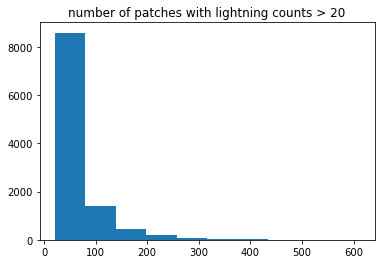

In [ ]:
print(f'fraction of zero flashes: {(train.flash_counts == 0).sum() / len(train.patch)}')
threshold = 20
plt.hist(train.flash_counts[np.argwhere(train.flash_counts.values > threshold).flatten()])
plt.title(f'number of patches with lightning counts > {threshold}')
plt.show()

Usually convective storms are dependent on the diurnal cycle. Check dependence on time of day.

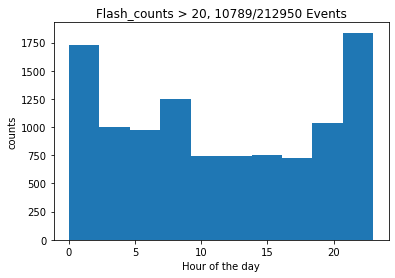

In [ ]:
ts_20plus = train.time[np.argwhere(train.flash_counts.values > 20).flatten()]
plt.hist(ts_20plus.dt.hour)
plt.title(f"Flash_counts > 20, {len(ts_20plus)}/{len(train.patch)} Events")
plt.ylabel("counts")
plt.xlabel("Hour of the day")
plt.savefig('test.png')

intrigued by their example kde plots, where during lightning the mean of the bands overlap more than with no lightning, so I made this. Seems to correlate

In [ ]:
spatmeans = train.mean(['x','y'])
fourteen_minus_eight = spatmeans.abi[:,-1] - spatmeans.abi[:,0]

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


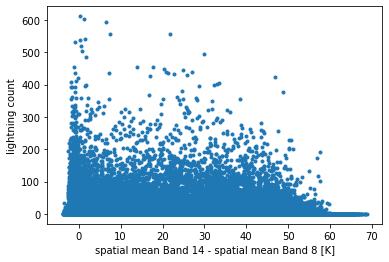

In [ ]:
plt.plot(fourteen_minus_eight,train.flash_counts, '.')
plt.xlabel("spatial mean Band 14 - spatial mean Band 8 [K]")
plt.ylabel("lightning count")
plt.savefig("minus.png")

### Check linear relations with spatial patch means

Fit a logistic to the two subtracted bands. With only the binary as response, and compare with models including all bands

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
spatm = train_in.reshape((train_in.shape[0],) + (32*32,4)).mean(axis = 1)
predictor = spatm[:,-1] - spatm[:,0]

valspatm = val_in.reshape((val_in.shape[0],) + (32*32,4)).mean(axis = 1)
valpredictor = valspatm[:,-1] - valspatm[:,0]

In [ ]:
log_full = LogisticRegression()
log_full.fit(X = spatm, y = train_out)
print(f'coefficients spatial mean 4 bands: {log_full.coef_}')
print(f'Accuracy: {log_full.score(X = valspatm, y=val_out)}')

log_full_scaled = LogisticRegression()
log_full_scaled.fit(X = scale(spatm, axis = 0), y = train_out)
print(f'coefficients spatial mean 4 bands, SCALED (per band): {log_full_scaled.coef_}')
print(f'Accuracy: {log_full_scaled.score(X = scale(valspatm, axis = 0), y=val_out)}')

log_oneprec = LogisticRegression()
log_oneprec.fit(X = predictor[:,np.newaxis], y = train_out)
print(f'coefficient spatial mean band 14 - band 8: {log_oneprec.coef_}')
print(f'Accuracy: {log_oneprec.score(X = valpredictor[:,np.newaxis], y = val_out)}')

coefficients spatial mean 4 bands: [[ 0.55906254 -0.41838901 -0.18057577  0.05188554]]
Accuracy: 0.7809918806012066


/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


coefficients spatial mean 4 bands, SCALED (per band): [[ 4.50500222 -4.06958825 -3.34355138  1.46460854]]
Accuracy: 0.7789407168541467


/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


coefficient spatial mean band 14 - band 8: [[-0.07555743]]
Accuracy: 0.7546376862471728


Strangely, standardization does not improve the logistic results. Coefficients do however become better interpretable. Information loss by reducing the band dimensions as band 14 - band 8 is not that large.
### Now test a different dimension reduction on spatial means
Now test how PCA distributes variability over the four bands. (Does any component relate to lightning? and )

In [ ]:
pca = PCA(n_components = 3)
pca.fit(spatm) # nsamples,n-features (i.e. n-bands)
print(pca.explained_variance_ratio_)
print(pca.components_)

[0.97694794 0.02133828 0.00165911]
[[-0.26051152 -0.35955733 -0.45121625 -0.77411634]
 [ 0.5051743   0.51971483  0.33093894 -0.6042968 ]
 [-0.6709039  -0.01903267  0.7181127  -0.18395503]]


The second component is positive for bands 1-3 and opposite for the 4th. 
The first component explains a very large part of the variance. We already noted earlier that bands are greatly correlated.

### Decision trees on pca-data

Text(0, 0.5, 'accuracy')

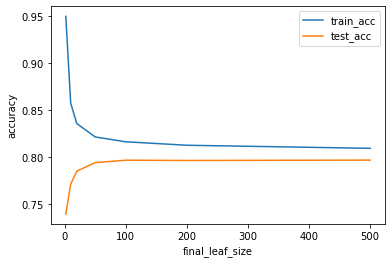

In [ ]:
pca_spatm_reduced = pca.transform(spatm)
pca_spatm_reduced_val = pca.transform(valspatm)
def setup_train_validate(model, modelkwargs: dict = {}) -> tuple:
    # fits the model and returns a tuple with (train_acc, validation_acc)
    learner = model(**modelkwargs)
    learner.fit(X = pca_spatm_reduced, y = train_out)
    acc_train = learner.score(X = pca_spatm_reduced, y=train_out)
    acc_test = learner.score(X = pca_spatm_reduced_val, y=val_out)
    return acc_train, acc_test

leafsizes = [2,10,20,50,100,200,500]
results_tree = [setup_train_validate(model = DecisionTreeClassifier, modelkwargs= {'min_samples_leaf':leafsize}) for leafsize in leafsizes]
pd.DataFrame(results_tree, index = pd.Index(leafsizes, name = 'final_leaf_size'), columns= ['train_acc','test_acc']).plot()
plt.ylabel('accuracy')

Actually the random forest does not improve hugely upon the single tree (there are also only four predictors.):

In [ ]:
setup_train_validate(RandomForestClassifier, dict(min_samples_leaf=100))

(0.8153092133732197, 0.7991915706698629)

### Decision Trees on all data

In [ ]:
!pip install xgboost

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import preprocessing
import xgboost as xgb 
from sklearn.decomposition import PCA

In [ ]:
# loading data:
X = train_in.reshape(train_in.shape[0],-1)
y = train_out
# compute statistical features
X_mean = np.mean(X , axis = 1).reshape(-1,1)
X_std  = np.std(X , axis = 1).reshape(-1,1)
X_max = np.max(X , axis = 1).reshape(-1,1)
X_min = np.min(X , axis = 1).reshape(-1,1)
X_median = np.median(X , axis = 1).reshape(-1,1)
X_var = np.var(X , axis = 1).reshape(-1,1)
X_feat = np.hstack([X_mean, X_std, X_max, X_min, X_median, X_var])

# Testing classifications
clf_DT_3 = DecisionTreeClassifier(criterion="entropy", max_depth=10)
clf_DT_3 = clf_DT_3 .fit(X_feat,y)
# test performance
X_val = val_in.reshape(val_in.shape[0],-1)
Xval_mean = np.mean(X_val , axis = 1).reshape(-1,1)
Xval_std  = np.std(X_val , axis = 1).reshape(-1,1)
Xval_max = np.max(X_val , axis = 1).reshape(-1,1)
Xval_min = np.min(X_val , axis = 1).reshape(-1,1)
Xval_median = np.median(X_val , axis = 1).reshape(-1,1)
Xval_var = np.var(X_val , axis = 1).reshape(-1,1)
X_feat_val = np.hstack([Xval_mean, Xval_std, Xval_max, Xval_min, Xval_median, Xval_var])
pred_out_DT = clf_DT_3.predict(X_feat_val)
pred_out_DT_probs = clf_DT_3.predict_proba(X_feat_val)
np.save('pred_out_DT.npy', pred_out_DT)
np.save('pred_out_DT_probs.npy', pred_out_DT_probs)
#print("dt_Accuracy:",metrics.accuracy_score(val_out, pred_out))
#print("dt_f1score:",metrics.f1_score(val_out, pred_out))

# testing random forest
#clf_RF = RandomForestClassifier(max_depth=10, random_state=0)
#clf_RF = clf_RF .fit(X_feat,y)
# test performance
#pred_out = clf_RF.predict(X_feat_val)
#print("RF_Accuracy:",metrics.accuracy_score(val_out, pred_out))
#print("RF_f1score:",metrics.f1_score(val_out, pred_out))

# scaling the data
sc =  preprocessing.StandardScaler()
scaled_X = sc.fit_transform(X_feat)
scaled_X_val = sc.transform(X_feat_val)
clf_RF_sc = RandomForestClassifier(max_depth=10, random_state=0)
clf_RF_sc = clf_RF_sc .fit(scaled_X,y)
pred_out_RF = clf_RF_sc.predict(scaled_X_val)
pred_out_RF_probs = clf_RF_sc.predict_proba(scaled_X_val)
np.save('pred_out_RF.npy', pred_out_RF)
np.save('pred_out_RF_probs.npy', pred_out_RF_probs)
print("scaled RF_Accuracy:",metrics.accuracy_score(val_out, pred_out_RF))
print("scaled RF_f1score:",metrics.f1_score(val_out, pred_out_RF))

# using xgboost
xgbo = xgb.XGBClassifier()
xgbo.fit(scaled_X,y)
pred_out_xgb = xgbo.predict(scaled_X_val)
pred_out_xgb_probs = xgbo.predict_proba(scaled_X_val)
np.save('pred_out_xgb.npy', pred_out_xgb)
np.save('pred_out_xgb_probs.npy', pred_out_xgb_probs)
print("xgboost_Accuracy:",metrics.accuracy_score(val_out, pred_out_xgb))
print("xgboost_f1score:",metrics.f1_score(val_out, pred_out_xgb))

# using raw data with PCA
x_std = sc.fit_transform(X)
x_val_std = sc.transform(X_val)
pca = PCA(n_components=10)
pca_X = pca.fit_transform(x_std)
pca_val = pca.transform(x_val_std)
xgbo = xgb.XGBClassifier()
xgbo.fit(pca_X,y)
pred_out_xgb_pca = xgbo.predict(pca_val)
pred_out_xgb_pca_probs = xgbo.predict_proba(pca_val)
np.save('pred_out_xgb_pca.npy', pred_out_xgb_pca)
np.save('pred_out_xgb_pca_probs.npy', pred_out_xgb_pca_probs)
print("pca_Accuracy:",metrics.accuracy_score(val_out, pred_out_xgb_pca))
print("pca_f1score:",metrics.f1_score(val_out, pred_out_xgb_pca))

scaled RF_Accuracy: 0.8484094704587285
scaled RF_f1score: 0.8031724739696948
xgboost_Accuracy: 0.8491717611422324
xgboost_f1score: 0.8073757629713129
pca_Accuracy: 0.858163782165407
pca_f1score: 0.8191456708018929


### Tuesday
* Train a densely connected neural network
* Train a convolutional or recurrent neural network (depends on problem)
* Experiment with different architectures

### Convolutional Neural network

In [ ]:
# Binary classification still.
loss = tf.keras.losses.BinaryCrossentropy()
cnn = StandardConvNet(loss=loss)
cnn.build_network(input_shape = scaled_train_in.shape[1:], output_size = 1)
cnn.compile_model()
# Checking the error before training. For binary classification the loss should be -sum(px log(qx) for x in 0,1)

In [ ]:
preds = cnn.predict(scaled_train_in)
pred_cnn_val=cnn.predict(scaled_val_in)
cnn.model.evaluate(x = scaled_train_in, y = train_out)

6644/6644 [==============================] - 35s 5ms/step - loss: 0.7011


0.7010531425476074

Indeed similar to:

In [ ]:
from sklearn.metrics import accuracy_score
theoretical = np.log(0.5) * - sum([(train_out == i).sum()/len(train_out) for i in [0,1]])
theoretical = -sum([(train_out == i).sum()/len(train_out) * np.log(0.5) for i in [0,1]])
print(f'theoretical cross entropy for random prediction: {theoretical}')
print(f'brier skill score: {brier_skill_score(train_out,preds)}')
print(f'accuracy score: {accuracy_score(y_true = train_out, y_pred = preds > 0.5)}')

theoretical cross entropy for random prediction: 0.6931471805599453
brier skill score: -0.09561428930015903
accuracy score: 0.3630411469210363


Now start fit and evaluation

In [ ]:
cnn.fit(x = scaled_train_in, y = train_out, build=False)
predsval = cnn.predict(scaled_val_in)
pred_cnn_train = cnn.predict(scaled_train_in)
pred_cnn_val = predsval

print(f'brier skill score: {brier_skill_score(val_out,predsval)}')
print(f'accuracy score: {accuracy_score(y_true = val_out, y_pred = predsval > 0.5)}')
cnn.model.summary()

{'loss': 0.44290629029273987}
{'loss': 0.34503841400146484}
{'loss': 0.32167941331863403}
{'loss': 0.3080383539199829}
{'loss': 0.29455530643463135}
{'loss': 0.2842468321323395}
{'loss': 0.277784526348114}
{'loss': 0.2712445855140686}
{'loss': 0.2654707729816437}
{'loss': 0.26350539922714233}
brier skill score: 0.6141237633005654
accuracy score: 0.8761277639306115
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
scn_input (InputLayer)       [(None, 32, 32, 4)]       0         
_________________________________________________________________
conv_00 (Conv2D)             (None, 32, 32, 16)        1616      
_________________________________________________________________
hidden_activation_00 (Activa (None, 32, 32, 16)        0         
_________________________________________________________________
pooling_00 (AveragePooling2D (None, 16, 16, 16)        0         
________________________

#### Convolutional neural network, shallow architecture
Lets try to cross-validate / optimize the batch size for a shallower neural net
We make the cnn shallower by increasing min_data_width

In [ ]:
def fit_one_fold(x_in, y_out, x_val, y_val, modelkwargs = {}):
    # Returns brier skill score and auc.
    loss = tf.keras.losses.BinaryCrossentropy()
    cnn2d = StandardConvNet(loss=loss, **modelkwargs)
    cnn2d.build_network(input_shape = x_in.shape[1:], output_size = 1 if y_out.ndim == 1 else y_out.shape[1])
    cnn2d.compile_model()
    print(f'fitting a model with {cnn2d.model.count_params()} params')
    cnn2d.fit(x = x_in, y = y_out, build = False)
    preds_val = cnn2d.predict(x_val)
    return brier_skill_score(y_val, preds_val), auc_score(y_val, preds_val)

def create_and_run_folds(kfolds, modelkwargs = {}):
    """
    Sequential splitting of the patches
    """
    n_patch = scaled_train_in.shape[0]
    blocklength = n_patch // kfolds
    returns = []
    for k in range(1,kfolds + 1):
        start = (k-1) * blocklength
        end = n_patch if k == kfolds else k * blocklength
        valind = np.logical_and(np.arange(n_patch) >= start, np.arange(n_patch) < end)
        returns.append(fit_one_fold(x_in = scaled_train_in[~valind,...], y_out = train_out[~valind,...],
                                   x_val = scaled_train_in[valind,...], y_val = train_out[valind], modelkwargs=modelkwargs))
    return pd.DataFrame(returns, index = pd.RangeIndex(1,kfolds + 1), columns = ['bss','auc'])

In [ ]:
largebatch = create_and_run_folds(kfolds = 3, modelkwargs = dict(batch_size = 512, min_data_width = 16))
smallerbatch = create_and_run_folds(kfolds = 3, modelkwargs = dict(batch_size = 128, min_data_width = 16))

fitting a model with 5713 params
{'loss': 0.47109079360961914}
{'loss': 0.42272117733955383}
{'loss': 0.38439837098121643}
{'loss': 0.3760196268558502}
{'loss': 0.36779066920280457}
{'loss': 0.3642213046550751}
{'loss': 0.36096614599227905}
{'loss': 0.35829249024391174}
{'loss': 0.352632611989975}
{'loss': 0.35075339674949646}
fitting a model with 5713 params
{'loss': 0.468658447265625}
{'loss': 0.4033087193965912}
{'loss': 0.3471260368824005}
{'loss': 0.3306732475757599}
{'loss': 0.3061369061470032}
{'loss': 0.2978319525718689}
{'loss': 0.2940364480018616}
{'loss': 0.29017725586891174}
{'loss': 0.28693488240242004}
{'loss': 0.28601065278053284}
fitting a model with 5713 params
{'loss': 0.44499820470809937}
{'loss': 0.3967624604701996}
{'loss': 0.3741742670536041}
{'loss': 0.35281309485435486}
{'loss': 0.3367137312889099}
{'loss': 0.32613733410835266}
{'loss': 0.32822221517562866}
{'loss': 0.32138749957084656}
{'loss': 0.31561166048049927}
{'loss': 0.31447330117225647}
fitting a model 

So cross validation functions:

In [ ]:
def fit_one_fold(x_in, y_out, x_val, y_val, modelkwargs = {}):
    """
    Does the training and testing for one fold.
    """
    loss = tf.keras.losses.BinaryCrossentropy()
    cnn2d = StandardConvNet(loss=loss, **modelkwargs)
    cnn2d.build_network(input_shape = x_in.shape[1:], output_size = 1 if y_out.ndim == 1 else y_out.shape[1])
    cnn2d.compile_model()
    print(f'fitting a model with {cnn2d.model.count_params()} params')
    cnn2d.fit(x = x_in, y = y_out, build = False)
    preds_val = cnn2d.predict(x_val)
    return brier_skill_score(y_val, preds_val), auc_score(y_val, preds_val)
def create_and_run_folds(kfolds, modelkwargs = {}):
    """
    Prepares the cross validation training and testing data into k-folds
    calls the fit_one_fold per fold.
    """
    n_patch = scaled_train_in.shape[0]
    blocklength = n_patch // kfolds
    returns = []
    for k in range(1,kfolds + 1):
        start = (k-1) * blocklength
        end = n_patch if k == kfolds else k * blocklength
        valind = np.logical_and(np.arange(n_patch) >= start, np.arange(n_patch) < end)
        returns.append(fit_one_fold(x_in = scaled_train_in[~valind,...], y_out = train_out[~valind,...],
                                   x_val = scaled_train_in[valind,...], y_val = train_out[valind], modelkwargs=modelkwargs))
    return pd.DataFrame(returns, index = pd.RangeIndex(1,kfolds + 1), columns = ['bss','auc'])

Running:

fitting a model with 5713 params
{'loss': 0.41154032945632935}
{'loss': 0.3688771426677704}
{'loss': 0.3630905747413635}
{'loss': 0.35876524448394775}
{'loss': 0.35492652654647827}
{'loss': 0.352004736661911}
{'loss': 0.3492577075958252}
{'loss': 0.348062127828598}
{'loss': 0.3459145426750183}
{'loss': 0.34512197971343994}
fitting a model with 5713 params
{'loss': 0.34286198019981384}
{'loss': 0.30145469307899475}
{'loss': 0.2919524013996124}
{'loss': 0.2881072163581848}
{'loss': 0.28316614031791687}
{'loss': 0.28065165877342224}
{'loss': 0.2785493731498718}
{'loss': 0.2754973769187927}
{'loss': 0.27470067143440247}
{'loss': 0.27258026599884033}
fitting a model with 5713 params
{'loss': 0.3703751862049103}
{'loss': 0.3271765112876892}
{'loss': 0.3163906931877136}
{'loss': 0.31070026755332947}
{'loss': 0.30498936772346497}
{'loss': 0.3037723898887634}
{'loss': 0.3016206920146942}
{'loss': 0.29867056012153625}
{'loss': 0.2972443401813507}
{'loss': 0.2950074374675751}
fitting a model with

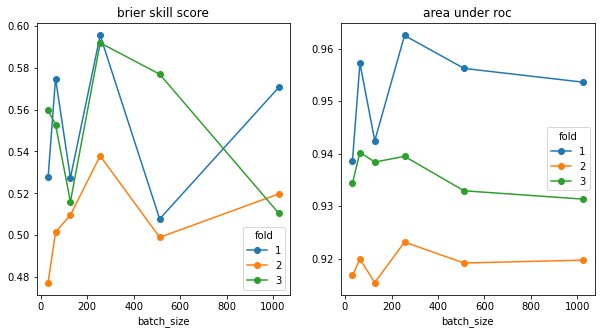

In [ ]:
batchsizes = [32,64,128,256,512,1024]
returns = []
for batch in batchsizes:
    returns.append(create_and_run_folds(kfolds = 3, modelkwargs = dict(batch_size = batch, min_data_width = 16, filter_growth_rate=1, pooling = 'max')))
#And collection + plotting:
scores = pd.concat(returns, keys= pd.Index(batchsizes, name = 'batch_size'), axis = 0)
scores.index = scores.index.rename(['batch_size','fold'])
scores = scores.unstack(-1)
fig, axes = plt.subplots(ncols=2, figsize = (10,5))
scores['bss'].plot(ax = axes[0], title = 'brier skill score', marker = 'o')
scores['auc'].plot(ax = axes[1], title = 'area under roc', marker = 'o')
plt.savefig('cv_batchsize.png')

Code to balance a training dataset:

In [ ]:
positives = np.argwhere(train_out == 1).squeeze()
negatives = np.random.choice(a = np.argwhere(train_out == 0).squeeze(), size = len(positives), replace = False )
indices = np.concatenate([positives,negatives])
train_out_balance = train_out[indices]
scaled_train_in_balance = scaled_train_in[indices,...]

Another try with convolutional neural network

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy()
# Unbalanced
good_model = StandardConvNet(loss=loss, min_data_width = 4, filter_growth_rate=2, pooling = 'max', batch_size=256, epochs=10)
good_model.fit(x = scaled_train_in, y = train_out)
# Performance on validation
pred_out_cnn2 = good_model.predict(scaled_val_in)
binary_threshold = 0.5
binary_pred_out_cnn2 = np.where(pred_out_cnn2 >= binary_threshold, 1, 0)
np.save('binary_pred_out_cnn2.npy', binary_pred_out_cnn2)
print(f'brier skill score: {brier_skill_score(val_out,binary_pred_out_cnn2)}')
print(f'auc score: {auc_score(val_out, binary_pred_out_cnn2)}')
print(f'accuracy score: {accuracy_score(y_true = val_out, y_pred = binary_pred_out_cnn2)}')

{'loss': 0.33867207169532776}
{'loss': 0.2756485044956207}
{'loss': 0.26124492287635803}
{'loss': 0.25303134322166443}
{'loss': 0.2481957972049713}
{'loss': 0.2428571879863739}
{'loss': 0.237157940864563}
{'loss': 0.23437854647636414}
{'loss': 0.23205797374248505}
{'loss': 0.22876329720020294}
brier skill score: 0.5629158268143961
auc score: 0.8882690159337957


NameError: name 'accuracy_score' is not defined

In [ ]:
#############################################
# logistic regression on two subtracted bands
#############################################
log_oneprec_preds=log_oneprec.predict(predictor[:,np.newaxis])
cm = confusion_matrix(train_out, log_oneprec_preds)
print('train conf matrix: logistic regression two subtracted bands ')
print(cm/np.sum(cm))
print()
log_oneprec_preds=log_oneprec.predict(valpredictor[:,np.newaxis])
cm = confusion_matrix(val_out, log_oneprec_preds)
print('val conf matrix: logistic regression two subtracted bands ')
print(cm/np.sum(cm))
print()
print()

#############################################
# logistic regression on PCA transformed data
#############################################
def setup_train_validate(model, inputdata, modelkwargs: dict = {}) -> tuple:
    # fits the model and returns a tuple with (train_acc, validation_acc)
    learner = model(**modelkwargs)
    learner.fit(X = pca_spatm_reduced, y = train_out)
    pred_val = np.asarray(learner.predict(inputdata))
    return pred_val

leafsizes = [200]
output = [setup_train_validate(model = DecisionTreeClassifier, inputdata=pca_spatm_reduced_val, modelkwargs= {'min_samples_leaf':leafsize}) for leafsize in leafsizes]
DTPCA_val = np.squeeze(np.asarray(output))
output = [setup_train_validate(model = DecisionTreeClassifier, inputdata=pca_spatm_reduced, modelkwargs= {'min_samples_leaf':leafsize}) for leafsize in leafsizes]
DTPCA_train = np.squeeze(np.asarray(output))


cm = confusion_matrix(train_out, DTPCA_train)
print('train conf matrix: Decision Tree on PCA transformed to 3 variables ')
print(cm/np.sum(cm))
print()
cm = confusion_matrix(val_out, DTPCA_val)
print('val conf matrix: Decision Tree on PCA transformed to 3 variables ')
print(cm/np.sum(cm))
print()
print()

#############################################
# gradient boosting on PCA transformed data
#############################################
XGB_train=xgbo.predict(pca_X)
XGB_val=xgbo.predict(pca_val)

cm = confusion_matrix(train_out,XGB_train)
print('train conf matrix: XGradient Boosting on PCA transformed to 3 variables ')
print(cm/np.sum(cm))
print()
cm = confusion_matrix(val_out, XGB_val)
print('val conf matrix: XGradient Boosting on PCA transformed to 3 variables ')
print(cm/np.sum(cm))
print()

#############################################
# cnn on PCA transformed data
#############################################
cm = confusion_matrix(train_out,pred_cnn_train)
print('train conf matrix: XGradient Boosting on PCA transformed to 3 variables ')
print(cm/np.sum(cm))
print()
cm = confusion_matrix(val_out, pred_cnn)
print('val conf matrix: XGradient Boosting on PCA transformed to 3 variables ')
print(cm/np.sum(cm))
print()

NameError: name 'log_oneprec' is not defined

### Wednesday
* Calculate three relevant evaluation metrics for each ML solution and baseline
* Refine machine learning approaches and test additional hyperparameter settings

In [ ]:
Loading saved validation results using base line, decision tree, random forest, XG Boost, and convolutional neural network

In [ ]:
import numpy as np
val_rnn = np.load("binary_preds.npy") # baseline
val_dt = np.load("pred_out_DT.npy") # decision tree
val_rf = np.load("pred_out_RF.npy") # random forest
val_xgb = np.load("pred_out_xgb.npy") # XG Boost
val_cnn = np.load("binary_pred_out_cnn2.npy") # CNN
val_obs = np.load("val_out.npy") # validation data
val_dat = np.vstack((val_rnn,val_dt, val_rf, val_xgb, val_cnn[:,0], val_obs))
val_dat = np.transpose(val_dat)
#np.savetxt('val_dat.csv', val_dat, delimiter=',')

In [ ]:
val_dat

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

### Calculate relevant metrics
Baseline metric performances - just show up again

In [ ]:
# regressed metrics
print('RMSE: {}'.format(np.round(root_mean_squared_error(val_dat[:,5], val_dat[:,0]),3)))
print('R squared: {}'.format(np.round(r2_corr(val_dat[:,5], val_dat[:,0]),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_dat[:,5], val_dat[:,0]),3)))

# classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_dat[:,5], val_dat[:,0]),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_dat[:,5], val_dat[:,0]),3)))
print('Brier Score: {}'.format(np.round(brier_score(val_dat[:,5], val_dat[:,0]),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_dat[:,5], val_dat[:,0]),3)))
print('AUC: {}'.format(np.round(roc_auc_score(val_dat[:,5], val_dat[:,0]),3)))

RMSE: 0.452
R squared: 0.395
Hellenger Distance: 0.006
Heidke Skill Score: 0.6
Pierce Skill Score: 0.64
Brier Score: 0.204
Brier Skill Score: 0.146
AUC: 0.82


Decision tree metric performances

In [ ]:
# regressed metrics
print('RMSE: {}'.format(np.round(root_mean_squared_error(val_dat[:,5], val_dat[:,1]),3)))
print('R squared: {}'.format(np.round(r2_corr(val_dat[:,5], val_dat[:,1]),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_dat[:,5], val_dat[:,1]),3)))

#  classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_dat[:,5], val_dat[:,1]),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_dat[:,5], val_dat[:,1]),3)))
print('Brier Score: {}'.format(np.round(brier_score(val_dat[:,5], val_dat[:,1]),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_dat[:,5], val_dat[:,1]),3)))
print('AUC: {}'.format(np.round(roc_auc_score(val_dat[:,5], val_dat[:,1]),3)))

RMSE: 0.394
R squared: 0.453
Hellenger Distance: 0.0
Heidke Skill Score: 0.673
Pierce Skill Score: 0.67
Brier Score: 0.156
Brier Skill Score: 0.349
AUC: 0.835


Random forest metric performances

In [ ]:
# regressed metrics
print('RMSE: {}'.format(np.round(root_mean_squared_error(val_dat[:,5], val_dat[:,2]),3)))
print('R squared: {}'.format(np.round(r2_corr(val_dat[:,5], val_dat[:,2]),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_dat[:,5], val_dat[:,2]),3)))

#  classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_dat[:,5], val_dat[:,2]),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_dat[:,5], val_dat[:,2]),3)))
print('Brier Score: {}'.format(np.round(brier_score(val_dat[:,5], val_dat[:,2]),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_dat[:,5], val_dat[:,2]),3)))
print('AUC: {}'.format(np.round(roc_auc_score(val_dat[:,5], val_dat[:,2]),3)))

RMSE: 0.389
R squared: 0.463
Hellenger Distance: 0.0
Heidke Skill Score: 0.68
Pierce Skill Score: 0.674
Brier Score: 0.152
Brier Skill Score: 0.366
AUC: 0.837


XGBoost metric performances

In [ ]:
# regressed metrics
print('RMSE: {}'.format(np.round(root_mean_squared_error(val_dat[:,5], val_dat[:,3]),3)))
print('R squared: {}'.format(np.round(r2_corr(val_dat[:,5], val_dat[:,3]),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_dat[:,5], val_dat[:,3]),3)))

#  classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_dat[:,5], val_dat[:,3]),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_dat[:,5], val_dat[:,3]),3)))
print('Brier Score: {}'.format(np.round(brier_score(val_dat[:,5], val_dat[:,3]),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_dat[:,5], val_dat[:,3]),3)))
print('AUC: {}'.format(np.round(roc_auc_score(val_dat[:,5], val_dat[:,3]),3)))

RMSE: 0.388
R squared: 0.467
Hellenger Distance: 0.0
Heidke Skill Score: 0.683
Pierce Skill Score: 0.681
Brier Score: 0.151
Brier Skill Score: 0.369
AUC: 0.841


CNN metric performances

In [ ]:
# regressed metrics
print('RMSE: {}'.format(np.round(root_mean_squared_error(val_dat[:,5], val_dat[:,4]),3)))
print('R squared: {}'.format(np.round(r2_corr(val_dat[:,5], val_dat[:,4]),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_dat[:,5], val_dat[:,4]),3)))

#  classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_dat[:,5], val_dat[:,4]),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_dat[:,5], val_dat[:,4]),3)))
print('Brier Score: {}'.format(np.round(brier_score(val_dat[:,5], val_dat[:,4]),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_dat[:,5], val_dat[:,4]),3)))
print('AUC: {}'.format(np.round(roc_auc_score(val_dat[:,5], val_dat[:,4]),3)))

RMSE: 0.323
R squared: 0.609
Hellenger Distance: 0.0
Heidke Skill Score: 0.78
Pierce Skill Score: 0.777
Brier Score: 0.104
Brier Skill Score: 0.563
AUC: 0.888


### Working with visualization
ROC Curve for decision tree algorithms

In [ ]:
val_out = np.load("val_out.npy")
r_probs = [0 for _ in range(len(val_out))]
r_dt_probs = np.load("pred_out_DT_probs.npy")[:,1]
r_rf_probs = np.load("pred_out_RF_probs.npy")[:,1]
r_xgb_probs = np.load("pred_out_xgb_probs.npy")[:,1]

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
# Calculate AUROC
r_auc = roc_auc_score(val_out, r_probs)
r_dt_auc = roc_auc_score(val_out, r_dt_probs)
r_rf_auc = roc_auc_score(val_out, r_rf_probs)
r_xgb_auc = roc_auc_score(val_out, r_xgb_probs)
print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
print('Decision Tree: AUROC = %.3f' % (r_dt_auc))
print('Random Forest: AUROC = %.3f' % (r_rf_auc))
print('XGBoost: AUROC = %.3f' % (r_xgb_auc))

Random (chance) Prediction: AUROC = 0.500
Decision Tree: AUROC = 0.916
Random Forest: AUROC = 0.924
XGBoost: AUROC = 0.926


In [ ]:
r_fpr, r_tpr, _ = roc_curve(val_out, r_probs)
dt_fpr, dt_tpr, _ = roc_curve(val_out, r_dt_probs)
rf_fpr, rf_tpr, _ = roc_curve(val_out, r_rf_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(val_out, r_xgb_probs)

In [ ]:
import matplotlib.pyplot as plt

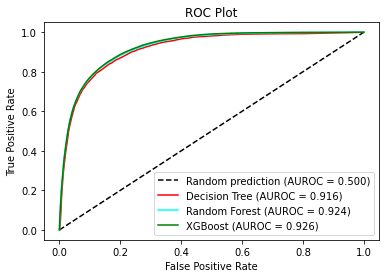

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(9,5),tight_layout=True)
ax1.plot(r_fpr, r_tpr, linestyle='--', color = 'black', label='Random prediction (AUROC = %0.3f)' % r_auc)
ax1.plot(dt_fpr, dt_tpr, color = 'red', label='Decision Tree (AUROC = %0.3f)' % r_dt_auc)
ax1.plot(rf_fpr, rf_tpr, color = 'cyan' , label='Random Forest (AUROC = %0.3f)' % r_rf_auc)
ax1.plot(xgb_fpr, xgb_tpr,  color = 'green', label='XGBoost (AUROC = %0.3f)' % r_xgb_auc)
# Title
#ax1.set_title('ROC Plot')
# Axis labels
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
# Show legend
fig.legend(loc='lower center',bbox_to_anchor=(0.8,0.15)) #
ax2.plot(r_fpr, r_tpr, linestyle='--', color = 'black')
ax2.plot(dt_fpr, dt_tpr, color = 'red')
ax2.plot(rf_fpr, rf_tpr, color = 'cyan')
ax2.plot(xgb_fpr, xgb_tpr,  color = 'green')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylim([0.7,1])
ax2.set_xlim([0.05,0.75])
fig.suptitle('ROC Plot',x=0.52,y=1.03)
fig.tight_layout()
# Show plot
plt.show()

### Thursday 
* Evaluate two interpretation methods for your machine learning solution
* Compare interpretation of baseline with your approach
* Submit best results on project to leaderboard
* Prepare 2 Google Slides on team's approach and submit them 

Plotting of confusion matrices

In [6]:
val_rnn = np.load("binary_preds.npy") # baseline
val_dt = np.load("pred_out_DT.npy") # decision tree
val_rf = np.load("pred_out_RF.npy") # random forest
val_xgb = np.load("pred_out_xgb.npy") # XG Boost
val_cnn = np.load("binary_pred_out_cnn2.npy") # CNN
val_obs = np.load("val_out.npy") # validation data
val_dat = np.vstack((val_rnn,val_dt, val_rf, val_xgb, val_cnn[:,0], val_obs))
val_dat = np.transpose(val_dat)
#np.savetxt('val_dat.csv', val_dat, delimiter=',')

from sklearn.metrics import confusion_matrix
def confusion_matrix_values(i):
    feat = confusion_matrix(val_dat[:,5],val_dat[:,i])
    feat_per = feat*100/feat.sum()
    return feat_per

from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
titles = ['Baseline','Decision Tree', 'Random Forest', 'XGBoost', 'CNN']
fig,ax = plt.subplots()
for z in [0,1,2,3,4]:
    colors_list = ['#FF6600','#FFFF00','#66FF33','#0066FF']
    n_bin = 4
    bounds = np.append(np.sort(confusion_matrix_values(z).flatten()),[50])
    norm = colors.BoundaryNorm(boundaries=bounds,ncolors = n_bin)
    cm = LinearSegmentedColormap.from_list('Blue-red',colors_list, N=n_bin)
    ax = fig.add_subplot(2,3,z+1)
    ax.imshow(confusion_matrix_values(z),cmap=cm,norm=norm)
    for i in range(confusion_matrix_values(z).shape[0]):
        for j in range(confusion_matrix_values(z).shape[1]):
            text = ax.text(j, i, np.round(confusion_matrix_values(z)[i, j],1),
                           ha="center", va="center", color="black")
    ax.set_title(titles[z])
    ax.axis('off')

FileNotFoundError: ignored

### Importance of predictors with a random forest.
Full pipeline, only train and val need to be predefined

In [13]:
# permutation tests for a random forest or gradient boosted forest. Input can thus be non-scaled data.
# As predictors, the min, max, mean of each band per patch, the hour of the day, plus a PCA combination of those statistics over those bands.
def prepare_data_plus_time(data):
    """
    Redefinition of above function, to also account for time of day
    """
    
    input_data = np.moveaxis(data['abi'].values, 1, -1)
    output_data = data['flash_counts'].values
    
    nan_indices = np.unique(np.where(np.isnan(input_data))[0])
    all_indices = np.arange(input_data.shape[0])
    valid_indices = all_indices[np.isin(all_indices, nan_indices, assume_unique=True, invert=True)]
    
    good_imagery = input_data[valid_indices]
    hr_of_day = data.time.dt.hour.values[valid_indices]
    binary_output = np.where(output_data > 0, 1, 0)[valid_indices]
    
    return good_imagery, hr_of_day, binary_output

train_in, train_hr, train_out = prepare_data_plus_time(train) 
val_in, val_hr, val_out = prepare_data_plus_time(val)

['.config', 'sample_data']

In [ ]:
# Train the forest with some previous (single tree) optimal leafsize settings.
clasif_forest = RandomForestClassifier(criterion='gini',min_samples_split=200, min_samples_leaf=50, n_jobs = 10)
clasif_forest.fit(X = train_preds, y = train_out)

#### Build in feature importance

In [ ]:
fix,ax = plt.subplots()
y_pos = np.arange(len(train_preds.columns))
ax.barh(y_pos, clasif_forest.feature_importances_, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(train_preds.columns)
plt.savefig('feat_importances.png')

### Single pass forward permutation

In [ ]:
#Function to permute a variable in the data, predict and score.
def single_pass_forward_permute(classifier, data_in, data_out, scores = [brier_skill_score, auc_score], scorenames = ['bss','auc']):
    outcomes = pd.DataFrame(index = data_in.columns, columns = pd.Index(scorenames,name = 'score'))
    for variable in data_in.columns:
        temp = data_in.copy() # Make sure that we are not overwriting by reference
        temp[variable] = temp[variable].sample(n = len(temp), replace = False).values
        prediction = classifier.predict_proba(X = temp)[:,classifier.classes_ == 1] # Prediction for positive, which is lightning
        outcomes.loc[variable] = [score(data_out, prediction) for score in scores]
    # Add the reference forecast:
    prediction = classifier.predict_proba(X = data_in)[:,classifier.classes_ == 1]
    outcomes.loc['reference'] = [score(data_out, prediction) for score in scores]
    return outcomes
train_perm = single_pass_forward_permute(clasif_forest, train_preds, train_out)
val_perm = single_pass_forward_permute(clasif_forest, val_preds, val_out)

In [ ]:
fix,[ax1,ax2] = plt.subplots(ncols=2, sharey= True, sharex=False, figsize = (8,4.5))
y_pos = np.arange(len(train_perm))
ax1.barh(y_pos, train_perm['bss'], align='center', label = 'train')
ax1.barh(y_pos, val_perm['bss'], align='center', label = 'validation')
ax1.set(xlim=[0.4, 0.72])
ax1.set_yticks(y_pos)
ax1.set_yticklabels(train_perm.index)
ax1.vlines(x = train_perm.loc['reference', 'bss'], ymin = y_pos.min(), ymax = y_pos.max(), linestyle = 'dashed', color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
ax1.vlines(x = val_perm.loc['reference', 'bss'], ymin = y_pos.min(), ymax = y_pos.max(), linestyle = 'dashed', color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
ax1.title.set_text('Brier Skill Score')
ax2.barh(y_pos, train_perm['auc'], align='center', label = 'train')
ax2.barh(y_pos, val_perm['auc'], align='center', label = 'validation')
ax2.set(xlim=[0.85, 0.98])
ax2.set_yticks(y_pos)
ax2.vlines(x = train_perm.loc['reference', 'auc'], ymin = y_pos.min(), ymax = y_pos.max(), linestyle = 'dashed', color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
ax2.vlines(x = val_perm.loc['reference', 'auc'], ymin = y_pos.min(), ymax = y_pos.max(), linestyle = 'dashed', color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
ax2.title.set_text('Area Under ROC Curve')
ax2.legend(loc = 'lower left')
plt.suptitle('Single pass forward permutation')
plt.savefig('perm_importances.png')

## Ultimate Submission Code
Please insert your full data processing and machine learning pipeline code in the cell below.